In [1]:
import pandas as pd
import numpy as np
import cv2
import os
from os.path import join as pjoin
from matplotlib import pyplot as plt
import random
import warnings
import keras
from keras.callbacks import EarlyStopping
from keras.regularizers import l2 
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,Conv1D,GlobalMaxPooling1D,MaxPooling1D
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D,AveragePooling1D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# first we can see what does the feature look like
def get_raw_feature():
    video_data_dir='C:\\videofeature\\'
    X=[]
    Y=[]
    for video in os.listdir(video_data_dir):
        each_video= pjoin(video_data_dir,video)
        l=each_video.split('t_')[1]
        l=l.split('.')[0]
        LABEL=int(l)
        X.append(np.load(each_video))
        Y.append(LABEL)
    Video_label=pd.read_csv('label.csv')
    Video_label=np.array(Video_label)[:,:-1]
    return X,Y


## 1 Read features from 19 npy files

In [3]:
X,Y=get_raw_feature()
Video_label=pd.read_csv('label.csv')
Video_label=np.array(Video_label)[:,:-1]
print('there are ',len(X),'videos')
print('feature of video [0]',X[0].shape)
print('video [0] is from video' ,Y[0])
print(Y)

there are  19 videos
feature of video [0] (739, 14)
video [0] is from video 1
[1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 3, 4, 5, 6, 7, 8, 9]


Video_label contains detail labels and we can use Y to index them later.

In [4]:
Video_label

array([[1.33, 1.67, 1.  , 1.67, 1.33, 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.67, 1.  , 1.  , 1.67, 1.33, 1.33],
       [4.33, 4.33, 4.33, 4.33, 5.  , 4.67],
       [2.33, 1.67, 2.  , 2.  , 3.  , 2.33],
       [3.33, 3.33, 2.67, 3.33, 4.  , 3.67],
       [4.67, 4.  , 4.  , 4.67, 5.  , 4.67],
       [2.  , 2.  , 1.33, 1.  , 1.33, 2.33],
       [1.33, 1.67, 1.33, 1.33, 1.  , 1.67],
       [2.67, 2.67, 2.67, 2.33, 3.33, 3.  ],
       [1.33, 1.67, 1.  , 1.33, 2.  , 1.33],
       [2.67, 2.67, 1.67, 2.67, 2.67, 2.33],
       [3.67, 3.33, 3.  , 3.  , 3.67, 3.33],
       [1.67, 2.  , 1.  , 1.67, 1.67, 2.  ],
       [5.  , 5.  , 5.  , 4.67, 5.  , 4.67],
       [1.33, 1.  , 1.33, 1.  , 1.  , 1.67],
       [1.67, 1.67, 1.  , 2.  , 2.33, 1.67],
       [4.33, 4.33, 4.  , 4.  , 4.33, 4.33],
       [4.  , 3.  , 3.  , 4.5 , 4.  , 4.  ],
       [4.  , 3.5 , 4.5 , 4.  , 4.5 , 4.5 ]])

Here we create two functions to sample video clips from each video and get their time differences.


In [5]:
def get_diff_and_hstack_to_orginal_data(X,time_lag=2,move_threshold=200):
    original=X[:-time_lag]
    modified=X[time_lag:]
    result=modified-original
    ## threshold
    # consider there was no top in the first image and it showed up in the next image
    # the difference would be huge, which was not ideal.
    # so we need to filter these extrem value 
    result[np.abs(result)>move_threshold]=0
    
    return np.hstack((X[time_lag:],result))

##from each video sample video clips with size=window_L. you can specify stride 
def make_video_clips(matrix,window_L,stride):
    alldata=[]

    total_frame=matrix.shape[0]
    index=[n for n in range(1,total_frame,stride)]
    for start_index in index:
        if start_index+window_L> total_frame:
            break
#         print(start_index)
        each_clip_data=matrix[start_index:start_index+window_L]
        each_clip_data=np.transpose(each_clip_data)
#         print(each_clip_data.shape)
        alldata.append(each_clip_data)
    return np.array(alldata)

## 2 pre-processing the feature
make new 28-d feature and  sample video clips

In [6]:
####################################### set video clips parameters
############################################### make new 28-d feature
video_clips_length=30
time_lag=3
move_threshold=250
stride=15

####################################### set video clips parameters
############################################### make new 28-d feature
all_data=[]
for each_video,label in zip(X,Y):

    re=get_diff_and_hstack_to_orginal_data(each_video,time_lag,move_threshold)
    video_clip=make_video_clips(re,video_clips_length,stride)
    print(video_clip.shape)
    all_data.append((video_clip))


(48, 28, 30)
(63, 28, 30)
(48, 28, 30)
(47, 28, 30)
(41, 28, 30)
(47, 28, 30)
(31, 28, 30)
(47, 28, 30)
(47, 28, 30)
(47, 28, 30)
(43, 28, 30)
(39, 28, 30)
(52, 28, 30)
(48, 28, 30)
(48, 28, 30)
(47, 28, 30)
(43, 28, 30)
(48, 28, 30)
(49, 28, 30)


So there are 19 videos and you can see how many video clips they have.

And next we will use leave one method to train the model.

## 3 prepare leave one data and give every video clips their label

In [7]:
# this function is used to stack 18 videos into a big matrix
# the dimenstion will be 
# (n1+n2..+n18,28,30)
# and the label will be (n1+n2..+n18,6)

def stack_video_clips_get_label(data,label):
    final_data=data[0]
    final_label=[label[0] for _ in range(final_data.shape[0])]
    for i in range(1,len(data)):
        final_data=np.vstack((final_data,data[i]))
        for j in range(data[i].shape[0]):
            final_label.append(label[i])
    return final_data,final_label

########## leave one and stack all video clips
def hold_out(X,Y,hold_number):
        new_label=Y.copy()
        new_data=X.copy()
        # find video n 's index
        index=new_label.index(hold_number)
        # get the video n and it's label
        X_test=new_data[index]
        hold_number_label=np.array([hold_number for _ in range(X_test.shape[0])])
        y_test=Video_label[hold_number_label-1]
        # so we can del them 
        del new_label[index]
        del new_data[index]

        final_data_X,final_data_Y=stack_video_clips_get_label(new_data,new_label)
        
        final_data_Y=np.array(final_data_Y)
        # the label of video 1 is Video_label[0]. 
        final_data_Y=Video_label[final_data_Y-1]
        return final_data_X,X_test,final_data_Y,y_test


In [8]:
# customized data generator
def generator(data, label, batch_size=128):
    while 1:
        rows = np.random.randint(0, data.shape[0], size=batch_size)
        samples = data[rows]
        y=label[rows]
        yield samples,y


In [9]:
# for each col, calculate the weighted average
def get_weighted_average(df):
    length=len(df)
    top=int(1/6*length)
    bottom=length-top
    df=np.array(df)
    df=np.sort(df)
    weghted_sum=np.sum(df[:top]*(1/6))+np.sum(df[top+1:bottom]*(2/3))+np.sum(df[bottom+1:]*(1/6))
    weghted_sum=weghted_sum/length
    return weghted_sum

# make the data frame
# Plot_data is the pridect result, which will have 6 scores
def get_video_score(Plot_data,GT):
    weight_ave_re=[]
    mean_re=[]
    median_re=[]
    pooled_re=[]
    
    for i in Plot_data.columns:
        weight_ave=get_weighted_average(Plot_data[i])
        weight_ave_re.append(weight_ave)
        
        mean_value=np.mean(Plot_data[i])   
        mean_re.append(mean_value)
        
        median_value = np.median(Plot_data[i])
        median_re.append(median_value)
        
        # pooling is also a weighted average 
        pooling = (weight_ave*0.2 + mean_value*0.2 + median_value*0.6)
        
        pooled_re.append(pooling)
        
    video_result=pd.DataFrame([weight_ave_re,mean_re,median_re,pooled_re,GT])
    video_result.columns = ['DP','BD','E','FS','A','RC']
    video_result.index = ['Weighted_average', 'Mean', 'Median','Cool_pooling','Ground_truth']
    return video_result
    


## 3 perform 80/20 train test split


In [10]:
# the model we will use
def make_model_1d(l2_lambda,clip_lenth,dimension):

    model = Sequential()
    model.add(Conv1D(filters=64, 
                     kernel_size=10, 
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                     kernel_regularizer=l2(l2_lambda)))
    
    model.add(Conv1D(filters=64, 
                     kernel_size=10, 
                     padding='same',
                     activation='relu',
                     kernel_regularizer=l2(l2_lambda)))
    
    model.add(MaxPooling1D(3,
                          padding='same'))
    
    model.add(Conv1D(filters=128, 
                     kernel_size=5, 
                     padding='same',
                     activation='relu',
                     kernel_regularizer=l2(l2_lambda)))
    model.add(Conv1D(filters=128, 
                     kernel_size=5, 
                     padding='same',
                     activation='relu',
                     kernel_regularizer=l2(l2_lambda)))
    
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='sigmoid'))
    
    model.compile(loss='mean_squared_error', # 'categorical_crossentropy' 'mean_squared_error' 'mean_absolute_percentage_error'
              optimizer='adam', # 'adadelta' 'rmsprop'
              )
    # model.summary()
    return model


In [11]:
stack_X, stack_Y=stack_video_clips_get_label(all_data,Y)
        
stack_Y=np.array(stack_Y)
# the label of video 1 is Video_label[0]. 
stack_Y=Video_label[stack_Y-1]
print(stack_X.shape)
print(stack_Y.shape)

(883, 28, 30)
(883, 6)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(stack_X, stack_Y, test_size=0.4)
print(X_train.shape)
print(X_test.shape)

(529, 28, 30)
(354, 28, 30)


loss 0.08493933081626892


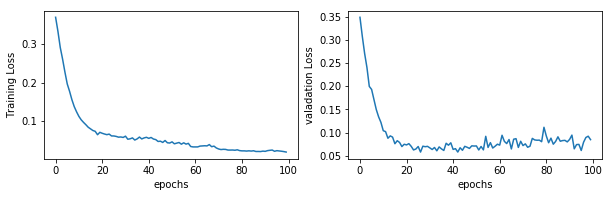

In [13]:
# scale all the value to 0-1
X_train=X_train/640
X_test=X_test/640
y_train=y_train/5
y_test=y_test/5
# print(X_train.shape,y_train.shape)
# print(X_test.shape,y_test.shape)

sample_of_trainningdata=X_train.shape[0]
sample_of_testdata=X_test.shape[0]


batch_size=128
L2=0.001
E=100


train_gen=generator(X_train, y_train, batch_size)
val_gen=generator(X_test, y_test, batch_size)

#prepare for inout shape
clip_lenth=X_train.shape[1]
dimension=X_train.shape[2]
#make cnn 1d
cnn1d=make_model_1d(L2,clip_lenth,dimension)
cnn1d_h=cnn1d.fit_generator(train_gen,
                    steps_per_epoch=int(sample_of_trainningdata/batch_size),
                    epochs=E,
                    validation_data=val_gen,
                   validation_steps=1,
                    verbose=0 )

ax=plt.figure(figsize=(10,6))
ax = plt.subplot(221)
ax.plot(cnn1d_h.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

ax = plt.subplot(222)
ax.plot(cnn1d_h.history['val_loss'])
plt.ylabel('valadation Loss')
plt.xlabel('epochs')

print('loss',cnn1d_h.history['val_loss'][-1])



In [14]:
all_video_score=[]
for video_number in range(len(all_data)):
    GT=list(Video_label[Y[video_number]-1])
    sample_video=all_data[video_number]
    sample_video=sample_video/640
    predict=cnn1d.predict(sample_video)
    re=predict*5
    Plot_data=pd.DataFrame(re,columns=['DP','BD','E','FS','A','RC'])
    video_result=get_video_score(Plot_data,GT)
    all_video_score.append(video_result)


In [15]:
all_video_score[1]

,DP,BD,E,FS,A,RC
Weighted_average,1.342287,1.254259,1.104822,1.275998,1.474422,1.383982
Mean,2.704227,2.532315,2.237300,2.574405,2.957417,2.785898
Median,2.671848,2.509905,2.216264,2.543459,2.937771,2.753299
Cool_pooling,2.412411,2.263258,1.998183,2.296156,2.649031,2.485955
Ground_truth,2.670000,2.670000,2.670000,2.330000,3.330000,3.000000


1


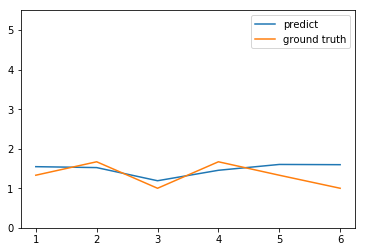

2


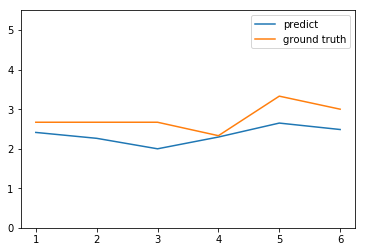

3


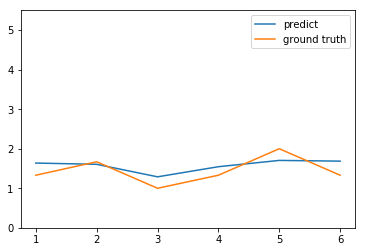

4


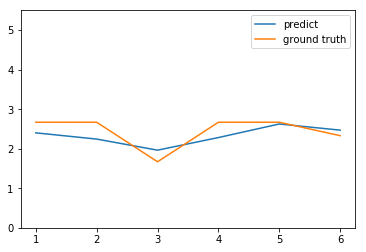

5


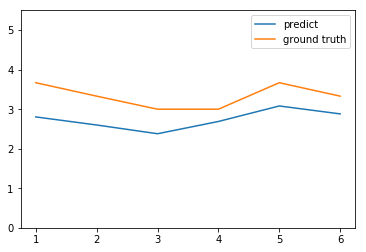

6


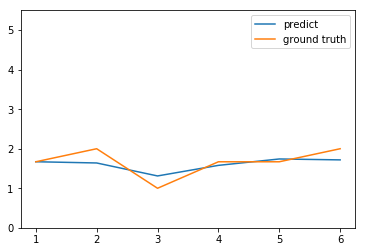

7


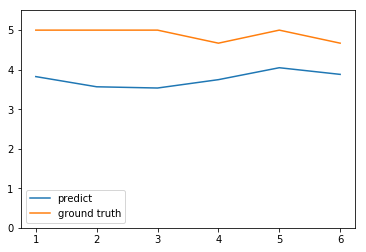

8


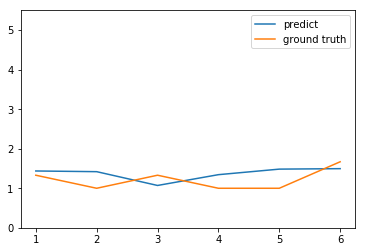

9


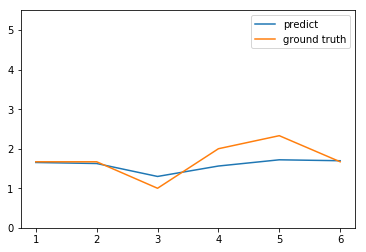

10


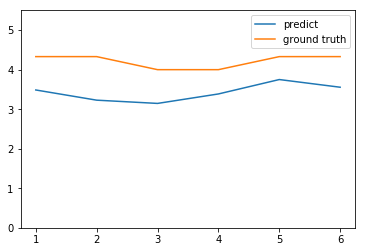

11


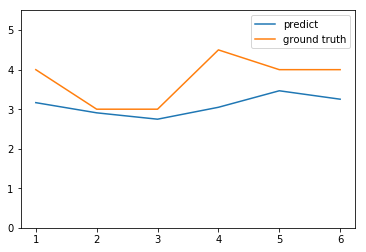

12


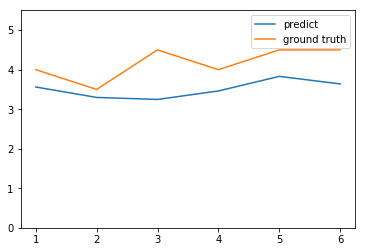

13


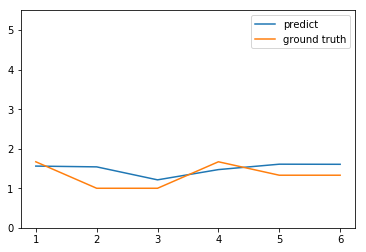

14


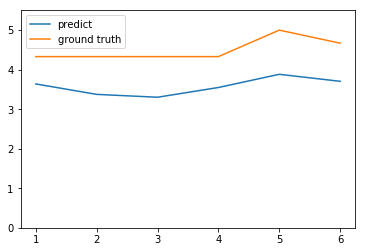

15


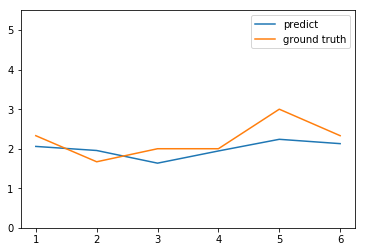

16


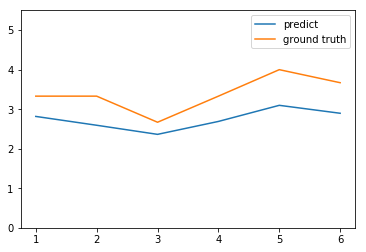

17


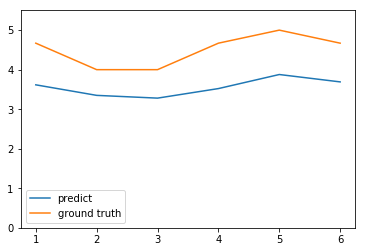

18


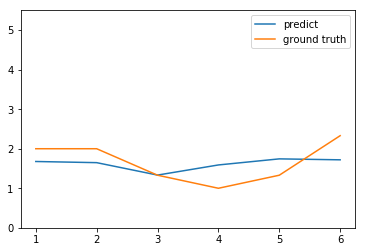

19


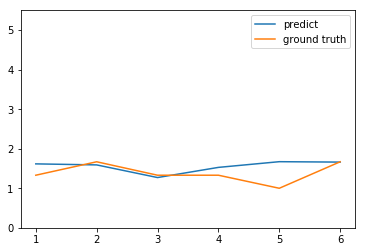

In [16]:
y=[x for x in range(1,7)]

i=1
for df in all_video_score:
    print(i)
    i=i+1
    ax = plt.subplot(111)
    gt=df.iloc[4]
    re=df.iloc[3]
    ax.plot(y, re, label='predict')
    ax.plot(y, gt, label='ground truth')
    plt.ylim(0,5.5)
    ax.legend()
    plt.show()